## Семинар 8: "LSTM"

ФИО: Богатенкова Анастасия Олеговна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

https://ru.coursera.org/lecture/machinnoe-obuchenie-v-finansah/riekurrientnyie-nieironnyie-sieti-rnn-sieti-dolghoi-kratkosrochnoi-pamiati-lstm-N08mN

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

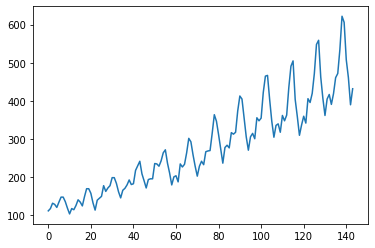

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
dataset.tail()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
139,606
140,508
141,461
142,390
143,432


In [5]:
# подготавливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size:], dataset[train_size:len(dataset):]
print(len(train), len(test))

96 48


In [7]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1 - look_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [8]:
# Пример подготовленных данных
look_back = 5
look_forward=1

trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
trainX.shape, testX.shape

((89, 1, 5), (41, 1, 5))

In [10]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [11]:
batch_size=5

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

### torch.nn.LSTM

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [12]:
# input_size = 1, for each month we have only 1 value i.e. total number of passengers
# hidden_size = 100, specifies the number of hidden layers along with the number of neurons in each layer

class Model_wrapper(nn.Module):
 
    def __init__(self, model, input_size, hidden_size, batch_size, 
                 output_size=1, num_layers=2):
        super(Model_wrapper, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = model(self.input_size, self.hidden_size, num_layers)
        self.linear = nn.Linear(self.hidden_size, output_size)
 
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size,
                            self.hidden_size, requires_grad=True),
                torch.zeros(self.num_layers, self.batch_size, 
                            self.hidden_size, requires_grad=True))
 
    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        y_pred = self.linear(lstm_out[-1].view(batch_size, -1))
        return y_pred[batch_size - len(input):]

In [13]:
input_size = 1
hidden_size = 50
learning_rate = 0.01

model = Model_wrapper(nn.LSTM, input_size, hidden_size, batch_size)

In [14]:
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100

hist = np.zeros(num_epochs)
 
for i in range(num_epochs):
    for X_train, y_train in train_dataloader:
        model.zero_grad()
        model.hidden = model.init_hidden()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    if i % 10 == 0:  
        print("Epoch ", i, "MSE: ", loss.item())
    hist[i] = loss.item()

Epoch  0 MSE:  0.01353437453508377
Epoch  10 MSE:  0.0265415757894516
Epoch  20 MSE:  0.006447308696806431
Epoch  30 MSE:  0.004594576079398394
Epoch  40 MSE:  0.005772730801254511
Epoch  50 MSE:  0.006074992008507252
Epoch  60 MSE:  0.005288746207952499
Epoch  70 MSE:  0.005374216008931398
Epoch  80 MSE:  0.005568703170865774
Epoch  90 MSE:  0.0016605966957286


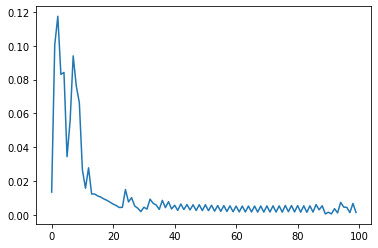

In [15]:
plt.plot(hist)
plt.show()

In [16]:
test_dataset = TensorDataset(torch.from_numpy(testX), 
                              torch.from_numpy(testY))

test_dataloader = DataLoader(test_dataset,
                              batch_size=1)
predictions = []
model.eval()

for X_test, y_test in test_dataloader:
    model.hidden = model.init_hidden()
    y_pred = model(X_test)
    predictions.append(y_pred[0].detach().numpy())

In [17]:
dataset.shape, len(predictions)

((144, 1), 41)

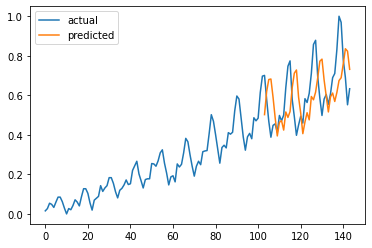

In [18]:
x = np.arange(144 - 41, 144, 1)

plt.plot(dataset, label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

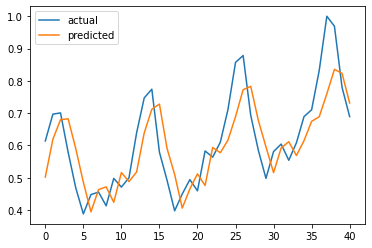

In [19]:
x = np.arange(len(predictions))

plt.plot(x, testY.ravel(), label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

### torch.nn.GRU

Epoch  0 MSE:  0.01644905097782612
Epoch  10 MSE:  0.014326783828437328
Epoch  20 MSE:  0.005707827862352133
Epoch  30 MSE:  0.0007350781233981252
Epoch  40 MSE:  0.0017656889976933599
Epoch  50 MSE:  0.003469837363809347
Epoch  60 MSE:  0.005279366858303547
Epoch  70 MSE:  0.0067823780700564384
Epoch  80 MSE:  0.015688341110944748
Epoch  90 MSE:  0.01522142719477415


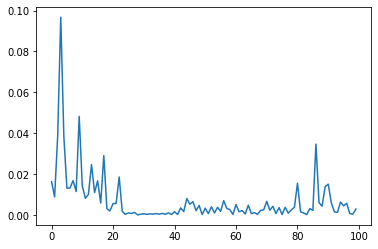

In [20]:
model = Model_wrapper(nn.GRU, input_size, hidden_size, batch_size)
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100

hist = np.zeros(num_epochs)
 
for i in range(num_epochs):
    for X_train, y_train in train_dataloader:
        model.zero_grad()
        model.hidden = model.init_hidden()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    if i % 10 == 0:  
        print("Epoch ", i, "MSE: ", loss.item())
    hist[i] = loss.item()
plt.plot(hist)
plt.show()

In [21]:
predictions = []
model.eval()

for X_test, y_test in test_dataloader:
    model.hidden = model.init_hidden()
    y_pred = model(X_test)
    predictions.append(y_pred[0].detach().numpy())

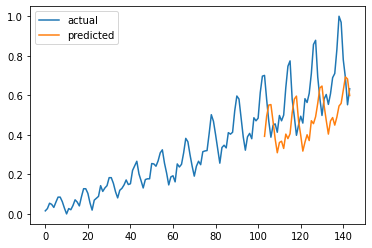

In [22]:
x = np.arange(144 - 41, 144, 1)

plt.plot(dataset, label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

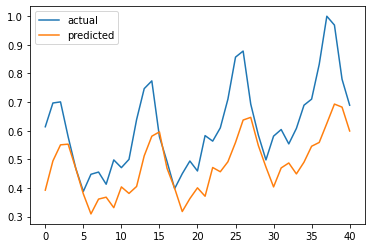

In [23]:
x = np.arange(len(predictions))

plt.plot(x, testY.ravel(), label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

### LSTM

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = LSTM(5, hidden_size)
        self.h2o = nn.Sequential(nn.Linear(hidden_size, 1))

    def forward(self, inp):
        hidden = (Variable(torch.zeros(batch_size, self.hidden_size)),
                  Variable(torch.zeros(batch_size, self.hidden_size)))
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        out = self.h2o(lstm_out.view(batch_size, self.hidden_size))
        return out[:inp.shape[0]]

Epoch  0 MSE:  0.05615267530083656
Epoch  10 MSE:  0.010488670319318771
Epoch  20 MSE:  0.007114713080227375
Epoch  30 MSE:  0.006943964399397373
Epoch  40 MSE:  0.006907373201102018
Epoch  50 MSE:  0.006897973828017712
Epoch  60 MSE:  0.006895247846841812
Epoch  70 MSE:  0.006893405690789223
Epoch  80 MSE:  0.0068931374698877335
Epoch  90 MSE:  0.006891559809446335
Epoch  100 MSE:  0.0069221872836351395
Epoch  110 MSE:  0.007912563160061836
Epoch  120 MSE:  0.007002036087214947
Epoch  130 MSE:  0.006924981251358986
Epoch  140 MSE:  0.006902860477566719
Epoch  150 MSE:  0.006895623169839382
Epoch  160 MSE:  0.007720921188592911
Epoch  170 MSE:  0.007624668534845114
Epoch  180 MSE:  0.006937556434422731
Epoch  190 MSE:  0.006918606348335743


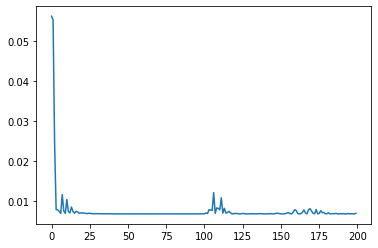

In [25]:
model = LSTMModel(10)
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 200
hist = np.zeros(num_epochs)

for i in range(num_epochs):
    for X_train, y_train in train_dataloader:
        model.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    if i % 10 == 0:  
        print("Epoch ", i, "MSE: ", loss.item())
    hist[i] = loss.item()
plt.plot(hist)
plt.show()

In [26]:
predictions = []
model.eval()

for X_test, y_test in test_dataloader:
    y_pred = model(X_test)
    predictions.append(y_pred[0].detach().numpy())

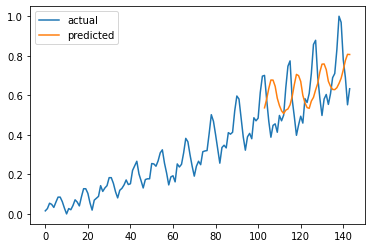

In [27]:
x = np.arange(144 - 41, 144, 1)

plt.plot(dataset, label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

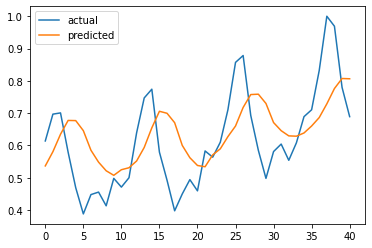

In [28]:
x = np.arange(len(predictions))

plt.plot(x, testY.ravel(), label="actual")
plt.plot(x, predictions, label="predicted")
plt.legend()
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: